In [1]:
import json
import ROOT
from analysis_framework import Dataset, WWAnalysis
import os

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x7caeba0


In [2]:
# ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad
# use same masses as in whizard!
mW = 80.419
mZ = 91.1882

In [4]:

ROOT.gSystem.Load("OO/diehl/libObservable.so")
ROOT.gInterpreter.Declare("#include \"OO/diehl/OOTools.h\"")
ROOT.OOTools.init(250, mW, mZ)

In [5]:
# dataset = Dataset.from_json("data/datasets/snapshots/full.json")
# dataset = Dataset.from_json("checked-test.json")
# dataset = Dataset.from_json("checked-full.json")
dataset = Dataset.from_json("checked-full-local.json")

In [6]:
analysis = WWAnalysis(dataset)
ROOT.gInterpreter.Declare("#include <podio/GenericParameters.h>")
analysis.Define("params_Energy", "Parameters.get<float>(\"Energy\").value_or(-1.0)")

In [7]:
# signal cut goes here:
# In this case, we want to require the charged lepton in the final state to be inside of the detector acceptance
# just take the first gen status 1 particle with a fitting pdg value and cut on theta
lep_pdg = 11
# CLD 150 mrad
# ILD ~84 mrad (IDR: 4.8 deg)
acceptance_theta = 0.084
signal_cut = f"""
std::invoke([](auto& genStat, auto& pdg, auto& px, auto& py, auto& pz, auto& m) -> bool {{
auto lepton_mask = genStat == 1 && abs(pdg) == {lep_pdg};
// abuse ArgMax to get the first set position
auto lepton_idx = ArgMax(lepton_mask);
auto lepton_lvec = ROOT::Math::PxPyPzMVector(px[lepton_idx], py[lepton_idx],
                                             pz[lepton_idx], m[lepton_idx]);
double lepton_theta = lepton_lvec.Theta();
return abs(cos(lepton_theta)) < cos({acceptance_theta});
}}, MCParticlesSkimmed.generatorStatus, MCParticlesSkimmed.PDG, MCParticlesSkimmed.momentum.x, MCParticlesSkimmed.momentum.y, MCParticlesSkimmed.momentum.z, MCParticlesSkimmed.mass)
"""

In [8]:
analysis.set_categories({
    # TODO: actually implement the cut, but I might notice when refactoring the cut-flow...
    # "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": "1 == 1"},
    # TODO: in principle I would not need to define them like this again if I would use the information from the pre-selection but did not manage that on first try :(
    "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": signal_cut},
    "4f_sl_bkg": {"pattern": r"4f\w+sl", "cut": None }, # inverse signal cut will be applied automatically
    "4f_not_sl": {"pattern": r"4f\w+_(?:h|l)", "cut": None },
    # separate out aa_4f? super low lumi anyway
    "aa2f": {"pattern": "aa_2f", "cut": None},
    # 2f but not aa_2f
    "2f": {"pattern": "(?<!aa_)2f", "cut": None},
    "3f": {"pattern": "ea_3f|ae_3f", "cut": None},
    "5f": {"pattern": "ea_5f|ae_5f", "cut": None},
    "6f": {"pattern": "6f", "cut": None},
    # need to filter out anything ending in _h and 2f_z_eehiq
    "higgs": {"pattern": "[^_e]h", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())

True


In [9]:
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_signal": [
    "4f_sw_sl_eLpL_signal_signal",
    "4f_sw_sl_eLpR_signal_signal",
    "4f_sw_sl_eRpR_signal_signal",
    "4f_sw_sl_eRpL_signal_signal",
    "4f_sw_sl_eLpL_bkg_signal",
    "4f_sw_sl_eLpR_bkg_signal",
    "4f_sw_sl_eRpR_bkg_signal",
    "4f_sw_sl_eRpL_bkg_signal"
  ],
  "4f_sl_bkg": [
    "4f_zz_sl_eLpR",
    "4f_zz_sl_eRpL",
    "4f_zznu_sl_eLpR",
    "4f_zznu_sl_eRpL",
    "4f_sze_sl_eLpL",
    "4f_sze_sl_eLpR",
    "4f_sze_sl_eRpR",
    "4f_sze_sl_eRpL",
    "4f_sznu_sl_eLpR",
    "4f_sznu_sl_eRpL",
    "4f_ww_sl_eLpR",
    "4f_ww_sl_eRpL",
    "4f_sw_sl_eLpL_signal_bkg",
    "4f_sw_sl_eLpR_signal_bkg",
    "4f_sw_sl_eRpR_signal_bkg",
    "4f_sw_sl_eRpL_signal_bkg",
    "4f_sw_sl_eLpL_bkg_bkg",
    "4f_sw_sl_eLpR_bkg_bkg",
    "4f_sw_sl_eRpR_bkg_bkg",
    "4f_sw_sl_eRpL_bkg_bkg"
  ],
  "4f_not_sl": [
    "4f_zz_h_eLpR",
    "4f_zz_h_eRpL",
    "4f_zz_l_eLpR",
    "4f_zz_l_eRpL",
    "4f_zzorww_h_eLpR",
    "4f_zzorww_l_eLpR",
    "4f_zzorww_l_eRpL",
    "

In [10]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))
# analysis.Define("n_neutral_PFOs", "Sum(abs(PandoraPFOs.charge) == 0.)")
# analysis.Define("charged_fraction", "n_charged_PFOs / static_cast<double>(n_charged_PFOs + n_neutral_PFOs)")

In [11]:
signal_category = ["4f_sw_sl_signal"]
analysis.define_truth_objects(signal_category)
analysis.define_reco_objects(x_angle)
analysis.remove_x_angle(x_angle)
analysis.define_hagiwara_angles()
analysis.define_OO()

In [12]:
# filter on missing energy > 0
analysis.Define("nu_E", "ub_nu_lvec.energy()")
analysis.Define("M_Wlep", "ub_leptonic_W_lvec.M()")
analysis.Define("M_Whad", "ub_hadronic_W_lvec.M()")
analysis.add_filter("M_Wlep > 0.", "Wlep real")

In [13]:
analysis.book_histogram_1D("O_1", "O_1", ("", ";O_1", 100, -1.5, 1.5))
analysis.book_histogram_1D("O_2", "O_2", ("", ";O_2", 100, -1.5, 1.5))
analysis.book_histogram_1D("O_3", "O_3", ("", ";O_3", 100, -1.5, 1.5))
analysis.book_histogram_1D("true_O_1", "true_O_1", ("", ";true_O_1", 100, -1.5, 1.5), signal_category)
analysis.book_histogram_1D("true_O_2", "true_O_2", ("", ";true_O_2", 100, -1.5, 1.5), signal_category)
analysis.book_histogram_1D("true_O_3", "true_O_3", ("", ";true_O_3", 100, -1.5, 1.5), signal_category)
analysis.book_histogram_1D("nu_E", "nu_E", ("", ";nu_E", 300, -50., 250.))
analysis.book_histogram_1D("M_Wlep", "M_Wlep", ("", ";M_Wlep", 300, -100., 200.))
analysis.book_histogram_1D("M_Whad", "M_Whad", ("", ";M_Whad", 160, 40., 200.))

In [14]:
analysis.book_reports()

In [15]:
analysis.book_OO_matrix()

In [16]:
%%time
analysis.run()

CPU times: user 3min 39s, sys: 10.1 s, total: 3min 49s
Wall time: 4min 20s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x34580400


In [17]:
analysis.print_reports()

       4f_sw_sl_signal             4f_sl_bkg             4f_not_sl                  aa2f                    2f                    3f                    5f                    6f                 higgs
        10449566 (1e+04)          641387 (1e+04)           87163 (1e+03)            4270 (4e+03)         1691836 (4e+04)           20318 (3e+03)            4307 (1e+02)               2 (3e-01)           16373 (9e+01) All
        10000121 (1e+04)          606268 (1e+04)           64530 (1e+03)               0 (0e+00)          716007 (2e+04)           13992 (2e+03)            4261 (1e+02)               2 (3e-01)           16222 (9e+01) Wlep real
            0.96            0.95            0.74           0e+00            0.42            0.69            0.99            0.95            0.99 efficiency


In [18]:
import numpy as np
c = analysis.get_OO_matrix_normalized()
print(c)
print(np.linalg.inv(c))

[[ 116.10979948 -348.4311616  -177.2705693 ]
 [-348.4311616  1356.82784909  661.62559583]
 [-177.2705693   661.62559583  537.94804291]]
[[ 0.03790571  0.00910179  0.00129676]
 [ 0.00910179  0.0040268  -0.00195327]
 [ 0.00129676 -0.00195327  0.00468858]]


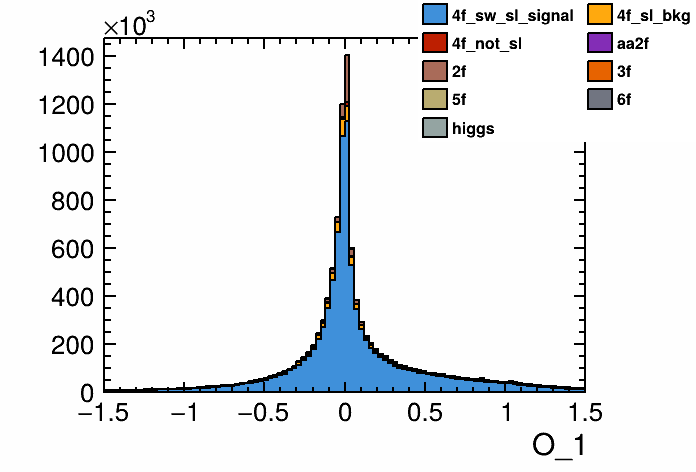

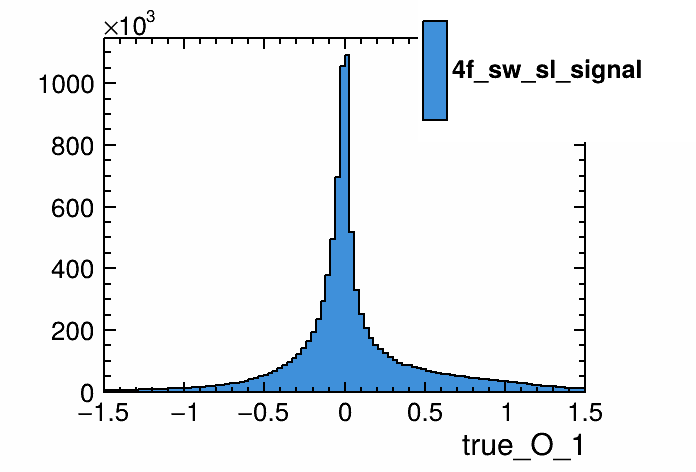

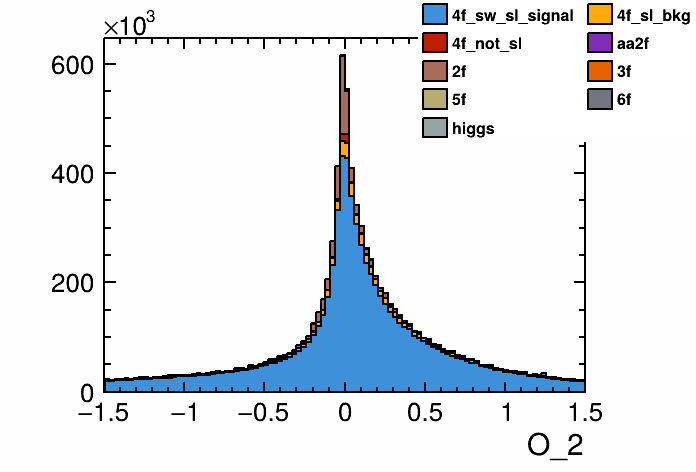

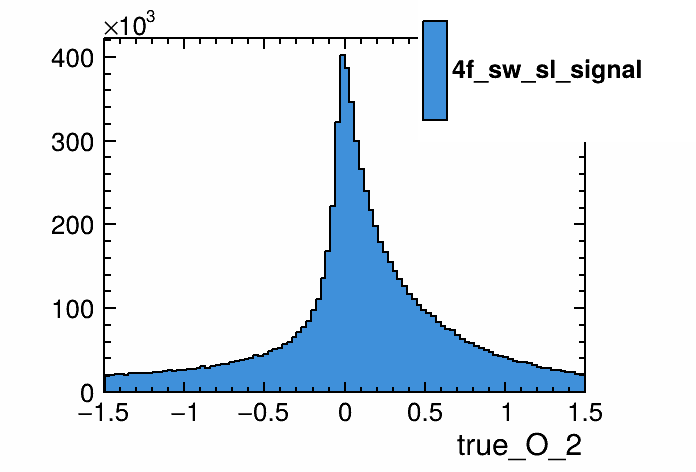

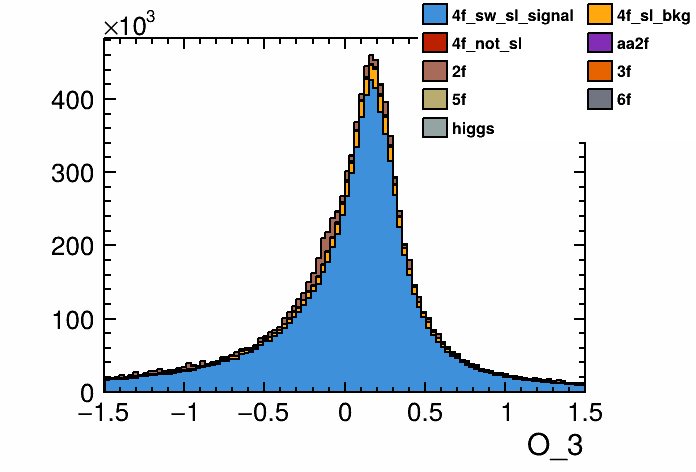

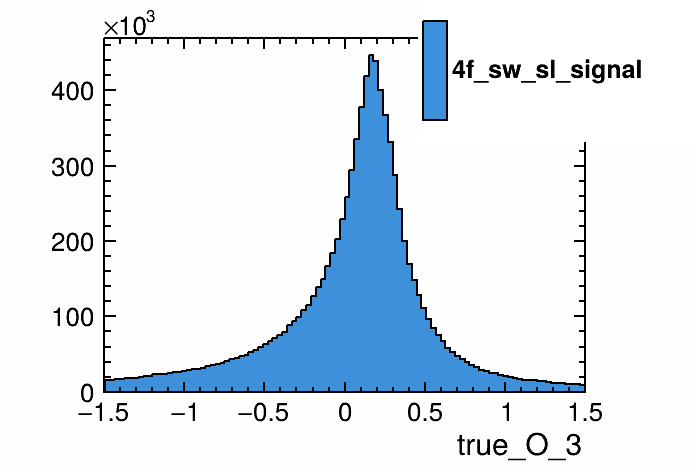

In [19]:
analysis.draw_histogram("O_1")
analysis.draw_histogram("true_O_1", categories=signal_category)
analysis.draw_histogram("O_2")
analysis.draw_histogram("true_O_2", categories=signal_category)
analysis.draw_histogram("O_3")
analysis.draw_histogram("true_O_3", categories=signal_category)

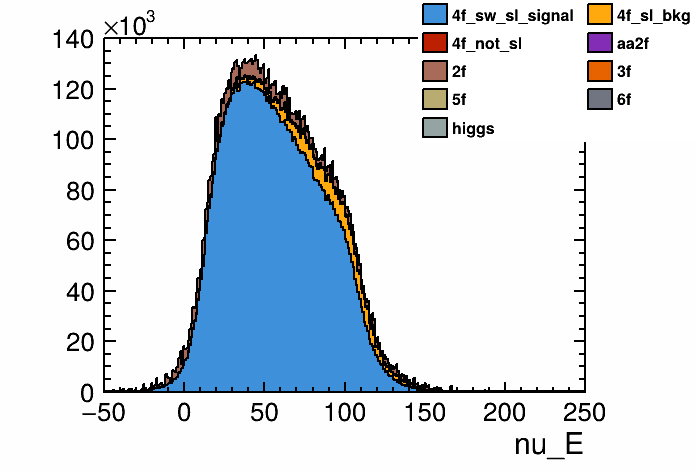

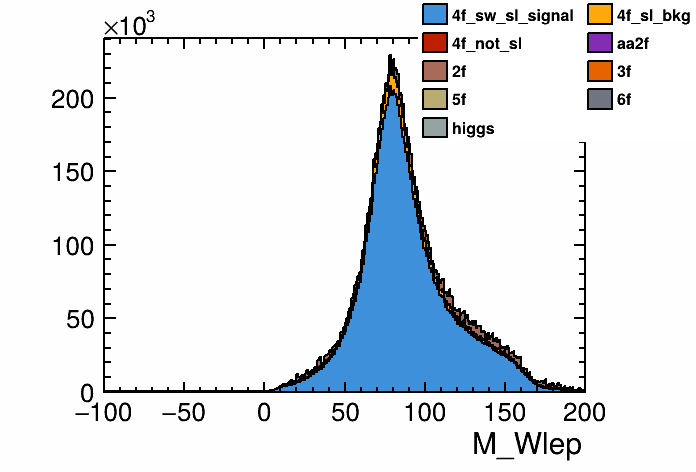

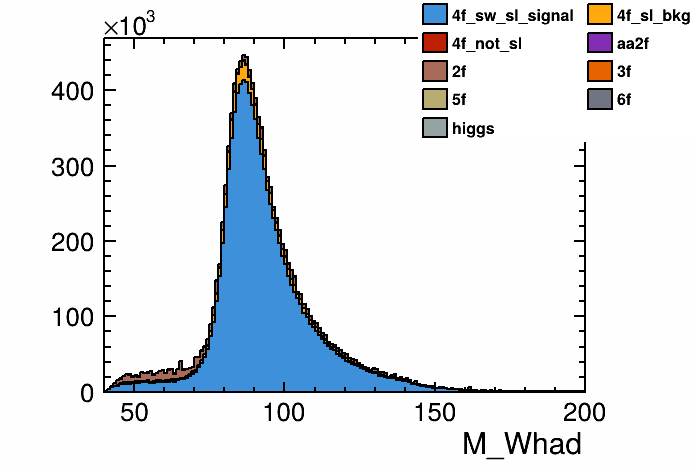

In [20]:
analysis.draw_histogram("nu_E")
analysis.draw_histogram("M_Wlep")
analysis.draw_histogram("M_Whad")